In [59]:
import pandas as pd 
import regex as re
from nltk import download
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

### 1. Reading the data set

In [3]:
df = pd.read_csv('../data/raw/url_spam.csv')
df.head()

,url,is_spam
0,https://briefingday.us8.list-manage.com/unsubs...,True
1,https://www.hvper.com/,True
2,https://briefingday.com/m/v4n3i4f3,True
3,https://briefingday.com/n/20200618/m#commentform,False
4,https://briefingday.com/fan,True


### 2. Data processing
#### 2.1 Categorical to numerical

In [5]:
df['is_spam'] = df['is_spam'].apply(lambda x: 1 if x==True else 0)
df.head()

,url,is_spam
0,https://briefingday.us8.list-manage.com/unsubs...,1
1,https://www.hvper.com/,1
2,https://briefingday.com/m/v4n3i4f3,1
3,https://briefingday.com/n/20200618/m#commentform,0
4,https://briefingday.com/fan,1


#### 2.2 Elimination of repeated values

In [6]:
print(f'Spam: {sum(df['is_spam'])}')
print(f'No spam: {len(df) - sum(df['is_spam'])}')
print(len(df))

Spam: 696
No spam: 2303
2999


In [7]:
df = df.drop_duplicates().reset_index(drop=True)
len(df)

2369

#### 2.3 Text processing

In [24]:
def preprocess_text(text):
    # Remove any character that is not a letter (a-z) or white space ( )
    text = re.sub(r'[^a-z ]', " ", text)
    
    # Remove white spaces
    text = re.sub(r'\s+[a-zA-Z]\s+', " ", text)
    text = re.sub(r'\^[a-zA-Z]\s+', " ", text)

    # Multiple white spaces into one
    text = re.sub(r'\s+', " ", text.lower())

    # Remove tags
    text = re.sub("&lt;/?.*?&gt;"," &lt;&gt; ", text)

    return text.split()

df['text'] = df['url'].apply(preprocess_text)
df.head()

,url,is_spam,text
0,https://briefingday.us8.list-manage.com/unsubs...,1,"[https, briefingday, us, list, manage, com, un..."
1,https://www.hvper.com/,1,"[https, www, hvper, com]"
2,https://briefingday.com/m/v4n3i4f3,1,"[https, briefingday, com, v, i]"
3,https://briefingday.com/n/20200618/m#commentform,0,"[https, briefingday, com, m, commentform]"
4,https://briefingday.com/fan,1,"[https, briefingday, com, fan]"


In [28]:
download("wordnet")
lemmatizer = WordNetLemmatizer()

download("stopwords")
stop_words = stopwords.words("english")

def lemmatize_text(words, lemmatizer = lemmatizer):
    tokens = [lemmatizer.lemmatize(word) for word in words]
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [word for word in tokens if len(word) > 3]
    return tokens

df['text'] = df['text'].apply(lemmatize_text)
df.head()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\noehu\AppData\Roaming\nltk_data...
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\noehu\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


,url,is_spam,text
0,https://briefingday.us8.list-manage.com/unsubs...,1,"[http, briefingday, list, manage, unsubscribe]"
1,https://www.hvper.com/,1,"[http, hvper]"
2,https://briefingday.com/m/v4n3i4f3,1,"[http, briefingday]"
3,https://briefingday.com/n/20200618/m#commentform,0,"[http, briefingday, commentform]"
4,https://briefingday.com/fan,1,"[http, briefingday]"


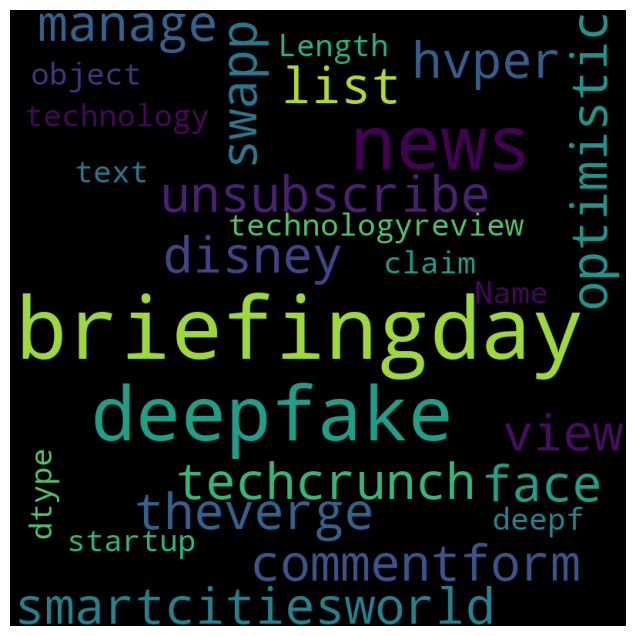

In [34]:
wordcloud = WordCloud(width=800, height=800, background_color="black", max_words=1000, min_font_size=20, random_state=123).generate(str(df["text"]))

fig = plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [40]:
tokens_list = df["text"]
tokens_list = [" ".join(tokens) for tokens in tokens_list]

vectorizer = TfidfVectorizer(max_features = 5000, max_df = 0.8, min_df = 5)
X = vectorizer.fit_transform(tokens_list).toarray()
y = df["is_spam"]

X[:5]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

#### 2.4 Train test split

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)

### 3. Initialization and training of the model

In [52]:
model = SVC(kernel = "linear", random_state = 123)
model.fit(X_train, y_train)

SVC(kernel='linear', random_state=123)

### 4. Model prediction

In [75]:
y_pred = model.predict(X_test)
print(f'Model Accuracy: {round(accuracy_score(y_test, y_pred)*100,2)}%')

Model Accuracy: 95.15%


### 5. Saving the model

In [ ]:
from pickle import dump 

dump(model, open('svm_classifier_linear_123.sav', 'wb'))